# Vectorized implementation of a neural network in NumPy

### Contents

* Calculating a gradient of the loss function with respect to the weights using backpropagation
* Gradient checking (calculating the gradient numerically)
* Updating neural network weights using gradient descent
* Visualizing the decision boundary of the final model

In [1]:
import numpy as np
from sklearn.datasets import make_circles

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Generating data

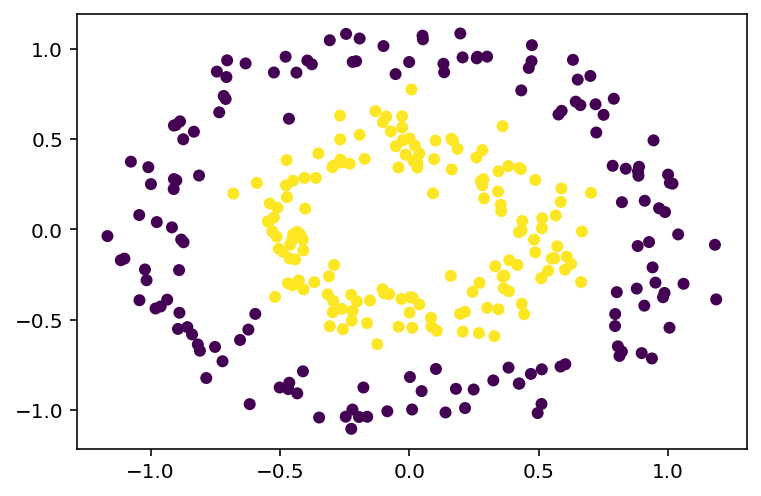

In [2]:
N = 300 # number of points
D = 2 # dimensionality
K = 2 # number of classes

X, y = make_circles(n_samples=N, noise=0.1, factor=0.5)

plt.scatter(x = X[:,0], y = X[:,1], c = y, cmap = 'viridis', edgecolor = 'none');

In [3]:
X.shape

(300, 2)

In [4]:
y.shape

(300,)

### Architecture

$x \in \mathbb{R}_{1\times2}$

$W_1 \in \mathbb{R}_{2\times10}$

$h \in \mathbb{R}_{1\times10}$

$W_2 \in \mathbb{R}_{100\times2}$

$prob \in \mathbb{R}_{1\times2}$

In [5]:
h_size = 10 # size of hidden layer
W1 = 0.01 * np.random.randn(D, h_size)
b1 = np.zeros((1, h_size))
W2 = 0.01 * np.random.randn(h_size, K)
b2 = np.zeros((1, K))

### Forward pass

First, let's calculate values in the hidden layer.

$$
h = \frac{1}{1 + e^{-(xW_1 + b_1)}}
$$

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
h = sigmoid(np.dot(X, W1) + b1)
h.shape

(300, 10)

Then, we calculate unnormalized class log probabilities

$$logprob = h W_2 + b_2$$

In [8]:
logprob = np.dot(h, W2) + b2

<span class='marginnote'>[Computing softmax and numerical stability](http://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/)</span>

Finally, we will use softmax function to get normalized class probabilities (distribution over all possible classes)

$$prob_i = \frac{e^{logprob_i}}{\sum_k{e^{logprob_k}}}$$

In [9]:
# Unnormalized probabilities
unnormalized_prob = np.exp(logprob - np.max(logprob))
# Normalized probabilities
prob = unnormalized_prob / np.sum(unnormalized_prob, axis=1, keepdims=True)

In [10]:
def forward(X, W1, b1, W2, b2):
    h = sigmoid(np.dot(X, W1) + b1)
    logprob = np.dot(h, W2) + b2
    unnormalized_prob = np.exp(logprob - np.max(logprob))
    prob = unnormalized_prob / np.sum(unnormalized_prob, axis=1, keepdims=True)
    
    return prob

prob = forward(X, W1, b1, W2, b2)
prob.shape

(300, 2)

### Loss function

To calculate a loss of the predicted probabilities $prob$ we will use cross entropy which is defined as

$$H(p, q) = -\sum_i{p_i \log{q_i}}$$

In our case, $p$ is a distribution of true classes so $p$ is a zero vector with one $1$ at index $y_1$, i.e. $p = [0, \ldots, 1, \ldots, 0]$, and $q$ is a vector of predicted class probabilities $prob$.

Since $p_i$ is zero for all $i$ except for $i = y_i$, we can simplify it as

$$H(p, q) = -\log{q_{y_i}}$$

So, we get

$$L_i = -\log{\left(prob_i\right)_{y_i}}$$

<span class='marginnote'>We can make sure that the weights are initialized randomly by calculating [expected loss](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/) and comparing it with our loss.</span>

In order to calculate an average loss across all data we get

$$
L = - \frac{1}{N} \sum_i^N{\log{\left(prob_i\right)_{y_i}}}
$$

In [11]:
def loss_fn(prob, y):
    return -np.log(prob[range(prob.shape[0]), y]).sum() / prob.shape[0]

In [12]:
loss = loss_fn(prob, y)
loss

0.6933599484431306

### Backpropagation

Now when we have the loss function we have to calculate its derivation with respect to $W_1$ and $W_2$, i.e. $\frac{\partial L}{\partial W_1}$ and $\frac{\partial L}{\partial W_2}$ respectively. We are going to calculate it using backpropagation, which is just a repeated application of chain rule.

$$
\frac{\partial L_i}{\partial W_1} = \frac{\partial L_i}{\partial logprob} \frac{\partial logprob}{\partial W_1} =
\frac{\partial L_i}{\partial logprob} \frac{\partial logprob}{\partial W_1} =
\frac{\partial L_i}{\partial logprob} \frac{\partial logprob}{\partial h} \frac{\partial h}{\partial W_1}
$$

$$
\frac{\partial L_i}{\partial W_2} = \frac{\partial L_i}{\partial logprob} \frac{\partial logprob}{\partial W_2}
$$

#### Calculating the gradient of the loss function with respect to the log probabilities

$$
\frac{\partial L_i}{\partial logprob_j} = \frac{\partial L_i}{\partial prob} \frac{\partial prob}{\partial logprob_j}
$$

<span class='marginnote'>
According to the [multivariable chain rule](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/differentiating-vector-valued-functions/a/multivariable-chain-rule-simple-version), $\frac{\partial \vec{y}_i}{\partial \vec{x}_j} = \sum_k^M \frac{\partial \vec{y}_i}{\partial \vec{m}_k} \frac{\partial \vec{m}_k}{\partial \vec{x}_j}$
</span>

$$
\frac{\partial L_i}{\partial prob} \frac{\partial prob}{\partial logprob_j} = \sum_k{\frac{\partial L_i}{\partial prob_k} \frac{\partial prob_k}{\partial logprob_j}}
$$

$$
\frac{\partial L_i}{\partial prob_k} = \frac{\partial -\log{prob_{y_i}}}{\partial prob_k} =
\begin{cases}
  - \frac{1}{prob_{y_i}} & \text{if}\ k = y_i \\
  0 & \text{otherwise}
\end{cases}
$$

$$\frac{\partial prob_k}{\partial logprob_j} = \frac{\partial e^{logprob_k} \left(\sum_i{e^{logprob_i}}\right)^{-1}}{\partial logprob_j}$$

I will use $\sum$ as a notation for $\sum_i{e^{logprob_i}}$

Now, we have to consider two cases for $k = j$ and $k \neq j$.

Let's start with the first case where $k = j$.

$$
\begin{aligned}
\frac{\partial e^{logprob_k} \left(\sum\right)^{-1}}{\partial logprob_j} &=
e^{logprob_k} \left(\sum\right)^{-1} + e^{logprob_k} (-1) \left(\sum\right)^{-2} \frac{\partial \sum}{\partial logprob_j} \\
&= e^{logprob_k} \left(\sum\right)^{-1} - e^{logprob_k} \left(\sum\right)^{-2} e^{logprob_j} \\
&= \frac{e^{logprob_k} \sum}{\sum^2} - \frac{e^{logprob_k} e^{logprob_j}}{\sum^2} \\
&= \frac{e^{logprob_k} \left(\sum - e^{logprob_j}\right)}{\sum^2} \\
&= \frac{e^{logprob_k}}{\sum} \left(\frac{\sum}{\sum} - \frac{e^{logprob_j}}{\sum}\right) \\
&= prob_k (1 - prob_j)
\end{aligned}
$$

And now the case where $k \neq j$.

$$
\begin{aligned}
\frac{\partial e^{logprob_k} \left(\sum\right)^{-1}}{\partial logprob_j} &=
0 + e^{logprob_k} \left(-1\right) \left(\sum\right)^{-2} \frac{\partial \sum}{\partial logprob_j} \\
&= e^{logprob_k} \left(-1\right) \left(\sum\right)^{-2} e^{logprob_j} \\
&= - \frac{e^{logprob_k}}{\sum} \frac{e^{logprob_j}}{\sum} \\
&= - prob_k prob_j
\end{aligned}
$$

That gives us

$$
\frac{\partial prob_k}{\partial logprob_j} =
\begin{cases}
  prob_k (1 - prob_j) & \text{if}\ k = j \\
  - prob_k prob_j & \text{otherwise}
\end{cases}
$$

$$
\frac{\partial L_i}{\partial logprob_j} = \frac{\partial L_i}{\partial prob} \frac{\partial prob}{\partial logprob_j} =
\sum_k{\frac{\partial L_i}{\partial prob_k} \frac{\partial prob_k}{\partial logprob_j}}
$$

Let's take a closer look at the expression inside the sum.

$$
\frac{\partial L_i}{\partial prob_k} \frac{\partial prob_k}{\partial logprob_j} =
\begin{cases}
  prob_j - 1 & \text{if}\ k = y_i, k = j, i = y_i\\
  prob_j & \text{if}\ k = y_i, k \neq j, j \neq y_i\\
  0 & \text{if}\ k \neq y_i
\end{cases}
$$

$$
\frac{\partial L_i}{\partial logprob_j} = \frac{\partial L}{\partial prob} \frac{\partial prob}{\partial logprob_j} =
\begin{cases}
  prob_j - 1 & \text{if}\ j = y_i \\
  prob_j & \text{otherwise}
\end{cases}
$$

Now when we know how to calculate gradient of the loss function $\frac{\partial L_i}{\partial logprob}$ we can easily  calculate $\frac{\partial L}{\partial logprob}$.

$$
L = \frac{1}{N} \sum_i^N L_i
$$

$$
\frac{\partial L}{\partial logprob} = \frac{1}{N} \frac{\partial L_i}{\partial logprob}
$$

In [13]:
dlogprob = prob
dlogprob[range(N), y] -= 1
dlogprob /= N
dlogprob.shape

(300, 2)

#### Calculating the gradient of the loss function with respect to the hidden layer

$$
\frac{\partial L_i}{\partial h} = \frac{\partial L_i}{\partial logprob} \frac{\partial logprob}{\partial h}
$$

Side note: Jacobian matrix

$$
\frac{\partial logprob}{\partial h} =
\begin{bmatrix}
\frac{\partial logprob_1}{\partial h_1} & \ldots & \frac{\partial logprob_1}{\partial h_{100}} \\
\vdots & \ddots & \vdots \\
\frac{\partial logprob_3}{\partial h_1} & \ldots & \frac{\partial logprob_3}{\partial h_{100}} \\
\end{bmatrix}_{3\times100}
$$

$$
logprob_k = h\left(W_2\right)_{\ast,k} + \left(b_2\right)_k = h_1 \left(W_2\right)_{1,k} + h_2 \left(W_2\right)_{2,k} + \cdots + h_n \left(W_2\right)_{n,k} + \left(b_2\right)_k
$$

$W_{\ast,k}$ denotes $k$th column of matrix $W$

$$\frac{\partial logprob_k}{\partial h_j} = (W_2)_{j,k}$$

$$
\frac{\partial logprob}{\partial h} =
\begin{bmatrix}
(W_2)_{1,1} & \ldots & (W_2)_{100,1} \\
\vdots & \ddots & \vdots \\
(W_2)_{1,3} & \ldots & (W_2)_{100,3} \\
\end{bmatrix} =
(W_2)^T
$$

$$
\begin{aligned}
\frac{\partial L_i}{\partial h_j} &= \frac{\partial L_i}{\partial logprob} \frac{\partial logprob}{\partial h_j} \\
&= \sum_k{\frac{\partial L_i}{\partial logprob_k} \frac{\partial logprob_k}{\partial h_j}} \\
&= \sum_k{\frac{\partial L_i}{\partial logprob_k} (W_2)_{j,k}} \\
&= \frac{\partial L_i}{\partial logprob} \left(\left(W_2\right)_{j,\ast}\right)^T \\
&= \frac{\partial L_i}{\partial logprob} \left(W_2^T\right)_{\ast,j}
\end{aligned}
$$

$$
\frac{\partial L_i}{\partial h} = \frac{\partial L_i}{\partial logprob} \left(W_2\right)^T
$$

In [14]:
dh = np.dot(dlogprob, W2.T)
dh.shape

(300, 10)

#### Calculating the gradient of the loss function with respect to the weights of the hidden layer

$$
\frac{\partial L_i}{\partial W_1} = \frac{\partial L_i}{\partial h} \frac{\partial h}{\partial W_1} =
\sum_k{\frac{\partial L_i}{\partial h_k} \frac{\partial h_k}{\partial W_1}}
$$

$$
h_k = \frac{1}{1 + e^{x \left(W_1\right)_{\ast, k} + \left(b_1\right)_k}} =
\frac{1}{1 + e^{x_1 \left(W_1\right)_{1, k} + x_2 \left(W_1\right)_{2, k} + \left(b_1\right)_k}}
$$

$$
\left(\frac{\partial h_k}{\partial W_1}\right)_{i,j} =
\frac{\partial h_k}{\partial (W_1)_{i,j}} =
\begin{cases}
  h_k (1 - h_k) x_i & \text{if}\ j = k \\
  0 & \text{otherwise}
\end{cases}
$$

So $\frac{\partial h_k}{\partial W_1}$ is a zero matrix with $h_k (1 - h_k) x^T$ in $k$th column.

<span class='marginnote'>
$\circ$ denotes [Hadamard (element wise) product](https://en.wikipedia.org/wiki/Hadamard_product_%28matrices%29)
</span>

$$
\begin{aligned}
\frac{\partial L_i}{\partial W_1} &=
\begin{bmatrix}
\frac{\partial L_i}{\partial h_1} h_1 (1 - h_1) x_1 & \ldots & \frac{\partial L_i}{\partial h_{100}} h_{100} (1 - h_{100}) x_1 \\
\frac{\partial L_i}{\partial h_1} h_1 (1 - h_1) x_2 & \ldots & \frac{\partial L_i}{\partial h_{100}} h_{100} (1 - h_{100}) x_2
\end{bmatrix} \\
&= x^T \left(\frac{\partial L_i}{\partial h} \circ h \circ \ (1 - h)\right)
\end{aligned}
$$

In [15]:
dW1 = X.T.dot(np.multiply(dh, np.multiply(h, 1 - h)))
dW1.shape

(2, 10)

#### Calculating the gradient of the loss function with respect to the bias of the input

$$
\frac{\partial L_i}{\partial b_1} =
\frac{\partial L_i}{\partial h} \frac{\partial h}{\partial b_1}
$$

$$
\frac{\partial L_i}{\partial \left(b_1\right)_j} =
\sum_k{\frac{\partial L_i}{\partial h_k} \frac{\partial h_k}{\partial \left(b_1\right)_j}}
$$

$$
\frac{\partial h_k}{\partial (b_1)_j} =
\frac{\partial \frac{1}{1 + e^{(xW_1)_k + (b_1)_k}}}{\partial (b_1)_j} =
\begin{cases}
  h_k (1 - h_k) & \text{if } k = j \\
  0 & \text{otherwise}
\end{cases}
$$

$$
\frac{\partial L_i}{\partial \left(b_1\right)_j} =
\frac{\partial L_i}{\partial h_j} h_j (1 - h_j)
$$

$$
\frac{\partial L_i}{\partial b_1} =
\frac{\partial L_i}{\partial h} \circ h \circ (1 - h)
$$

In [16]:
db1 = np.multiply(dh, np.multiply(h, 1 - h))
db1 = np.sum(db1, axis=0, keepdims=True)
db1.shape

(1, 10)

#### Calculating the gradient of the loss function with respect to the weights of the output layer

$$
\frac{\partial L_i}{\partial W_2} = \frac{\partial L_i}{\partial logprob} \frac{\partial logprob}{\partial W_2} =
\sum_k{\frac{\partial L_i}{\partial logprob_k} \frac{\partial logprob_k}{\partial W_2}}
$$

$$
\frac{\partial logprob_k}{\partial W_2} =
\begin{bmatrix}
\frac{\partial logprob_k}{\partial \left(W_2\right)_{1,1}} & \ldots & \frac{\partial logprob_k}{\partial \left(W_2\right)_{1,3}} \\
\vdots & \ddots & \vdots \\
\frac{\partial logprob_k}{\partial \left(W_2\right)_{100,1}} & \ldots & \frac{\partial logprob_k}{\partial \left(W_2\right)_{100,3}} \\
\end{bmatrix}
$$

$$
logprob_k = h\left(W_2\right)_{\ast,k} + \left(b_2\right)_k = h_1 \left(W_2\right)_{1,k} + h_2 \left(W_2\right)_{2,k} + \cdots + h_n \left(W_2\right)_{n,k} + \left(b_2\right)_k
$$

$$
\frac{\partial logprob_k}{\partial \left(W_2\right)_{i,j}} =
\begin{cases}
  h_i & \text{if}\ j = k \\
  0 & \text{otherwise}
\end{cases}
$$

$\frac{\partial logprob_k}{\partial W_2}$ is a zero matrix with $h^T$ in the $k$th column.

$$
\sum_k{\frac{\partial L_i}{\partial logprob_k} \frac{\partial logprob_k}{\partial W_2}} =
\begin{bmatrix}
\frac{\partial L_i}{\partial logprob_1} h_1 & \ldots & \frac{\partial L_i}{\partial logprob_3} h_1 \\
\vdots & \ddots & \vdots \\
\frac{\partial L_i}{\partial logprob_1} h_{100} & \ldots & \frac{\partial L_i}{\partial logprob_3} h_{100} \\
\end{bmatrix} =
h^T \frac{\partial L_i}{\partial logprob}
$$

In [17]:
dW2 = np.dot(h.T, dlogprob)
dW2.shape

(10, 2)

#### Calculating the gradient of the loss function with respect to the bias of the hidden layer

$$
\frac{\partial L_i}{\partial b_2} = \frac{\partial L_i}{\partial logprob} \frac{\partial logprob}{\partial b_2}
$$

$$
\frac{\partial L_i}{\partial \left(b_2\right)_j} =
\frac{\partial L_i}{\partial logprob} \frac{\partial logprob}{\partial \left(b_2\right)_j} =
\sum_k{\frac{\partial L_i}{\partial logprob_k} \frac{\partial logprob_k}{\partial \left(b_2\right)_j}}
$$

$$
logprob_k = h\left(W_2\right)_{\ast,k} + \left(b_2\right)_k
$$

$$
\frac{\partial logprob_k}{\partial \left(b_2\right)_j} =
\begin{cases}
1 & \text{if } k = j \\
0 & \text{otherwise}
\end{cases}
$$

$$
\sum_k{\frac{\partial L_i}{\partial logprob_k} \frac{\partial logprob_k}{\partial \left(b_2\right)_j}} =
\frac{\partial L_i}{\partial logprob_j}
$$

$$
\frac{\partial L_i}{\partial b_2} = \frac{\partial L_i}{\partial logprob}
$$

In [18]:
db2 = np.sum(dlogprob, axis=0, keepdims=True)
db2.shape

(1, 2)

### Gradient checking

Calculating the gradient analytically using backpropagation is computationally efficient but as you can see it involves a lot of math and is therefore quite error prone.

Another way of calculating the gradient is calculating it numerically. This method is computationally very expensive but on the other hand is really simple to implement. Because of that, it is commonly used for checking a correctness of a backpropagation implementation.

In [19]:
params = [W1, b1, W2, b2]
gradients = [dW1, db1, dW2, db2]

# eps = 0.00001
eps = 0.0000001

loss = loss_fn(forward(X, *params), y)

for param_id in range(len(params)):
    for i in range(params[param_id].shape[0]):
        for j in range(params[param_id].shape[1]):
            old_param = params[param_id][i][j]
            params[param_id][i][j] += eps
            loss_eps = loss_fn(forward(X, *params), y)
            params[param_id][i][j] = old_param
            
            grad_num = (loss_eps - loss) / eps
            if not np.isclose(grad_num, gradients[param_id][i][j]):
                print('({}, {}, {}) Numerical gradient of {} ' + \
                      'is not close to backpropagation ' + \
                      'gradient of {}'.format(param_id, i, j, grad_num, gradients[param_id][i][j]))

### Gradient descent

Once we know how to calculate the gradient we can use gradient descent to iteratively update the weights and biases.

In [20]:
np.seterr(all='raise')

h_size = 10 # size of hidden layer
W1 = 0.01 * np.random.randn(D, h_size)
b1 = np.zeros((1, h_size))
W2 = 0.01 * np.random.randn(h_size, K)
b2 = np.zeros((1, K))

step_size = 1e-0

for i in range(10000):
    h = sigmoid(np.dot(X, W1) + b1)
    logprob = np.dot(h, W2) + b2
    unnormalized_prob = np.exp(logprob - np.max(logprob))
    prob = unnormalized_prob / np.sum(unnormalized_prob, axis=1, keepdims=True)

    loss = loss_fn(prob, y)
    
    if i % 1000 == 0:
        print('Iteration {}: loss {}'.format(i, loss))

    dlogprob = prob
    dlogprob[range(N), y] -= 1
    dlogprob /= N

    dh = np.dot(dlogprob, W2.T)

    dW1 = X.T.dot(np.multiply(dh, np.multiply(h, 1 - h)))

    db1 = np.multiply(dh, np.multiply(h, 1 - h))
    db1 = np.sum(db1, axis=0, keepdims=True)

    dW2 = np.dot(h.T, dlogprob)
    db2 = np.sum(dlogprob, axis=0, keepdims=True)

    W1 += -step_size * dW1
    b1 += -step_size * db1
    W2 += -step_size * dW2
    b2 += -step_size * db2

Iteration 0: loss 0.6931495475910147
Iteration 1000: loss 0.6931400669938796
Iteration 2000: loss 0.6930967259104385
Iteration 3000: loss 0.6930570954846387
Iteration 4000: loss 0.6929718203393668
Iteration 5000: loss 0.5337988779559123
Iteration 6000: loss 0.06802064314390055
Iteration 7000: loss 0.04739387134950528
Iteration 8000: loss 0.03739035113950339
Iteration 9000: loss 0.03034828472104865


### Visualizing the decision boundary

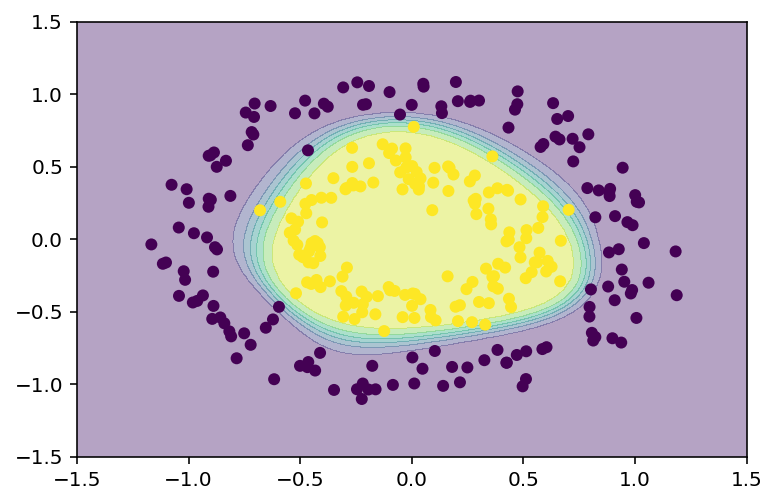

In [21]:
n = 100
xc = np.linspace(-1.5, 1.5, num = n)
yc = np.linspace(-1.5, 1.5, num = n)
xx, yy = np.meshgrid(xc, yc)
zc = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        prob = forward([[xx[i,j], yy[i,j]]], W1, b1, W2, b2)
        zc[i][j] = prob[0][1]

cmap = 'viridis'
plt.contourf(xc, yc, zc, cmap = cmap, alpha = 0.4)
plt.scatter(x = X[:,0], y = X[:,1], c = y, cmap = cmap, edgecolor = 'none')
plt.show()

### Resources

* [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/)
* [Vector, Matrix, and Tensor Derivatives](http://cs231n.stanford.edu/vecDerivs.pdf)
* [The Softmax function and its derivative](http://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/)
* [How to implement a neural network: Intermezzo 2](http://peterroelants.github.io/posts/neural_network_implementation_intermezzo02/)
* [Implementing a Neural Network from Scractch in Python – An Introduction](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)
* [A Friendly Introduction to Cross-Entropy Loss](https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/)
* [ReLU](http://kawahara.ca/ipython/ReLU.html)